In [50]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC, Constant
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem
import matplotlib.pyplot as plt

from scipy.stats import multivariate_normal
from scipy.stats import norm as normal

from firedrake.petsc import PETSc

import os
from pathlib import Path
fig_path = Path.home() / 'Dropbox' / 'phd' / 'projects' / 'stat-fem' / 'meeting-notes'

from tqdm import tqdm

In [51]:
# specify the prior for omega
omega_prior_loc = 1.0
omega_prior_scale = 1e-1


def omega_prior_logpdf(omega, loc, scale):
    return normal.logpdf(omega, loc, scale)

def omega_prior_sample(loc, scale):
    return np.random.normal(loc=loc, scale=scale)

def omega_proposal_logpdf(omega_from, omega_to, prop_std):
    return normal.logpdf(omega_to, omega_from, prop_std)

def omega_proposal_sample(omega, prop_std):
    return np.random.normal(omega, prop_std)
# specify the epsilon_f

In [52]:
num_samples = 1000

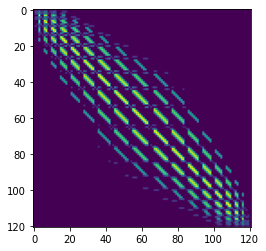

In [53]:
nx = 11

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

M = mesh.coordinates.vector().dat.data.shape[0]

u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)
f.interpolate(Constant(10))


L = f * v * dx
b = assemble(L)
b_np = b.vector().dat.data

bc = [DirichletBC(V, 1, 2), DirichletBC(V, 1, 4)]


log_sigma_f = np.log(2)
log_l_f = np.log(0.2)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=5e-1)
G.assemble()
G_np = G.G.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
G_inv_np = np.linalg.inv(G_np)
plt.imshow(G_np)

## Monte Carlo estimate

In [41]:
u_mean_samples_mc = np.zeros((num_samples, M))
u_samples_mc = np.zeros((num_samples, M))

for n in tqdm(range(num_samples)):
    omega_n = Constant(omega_prior_sample(omega_prior_loc, omega_prior_scale))
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    a =  (dot(grad(v), omega_n * grad(u_trial))) * dx
    A = assemble(a, bcs=bc)
    A_inv = np.linalg.inv(A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32)))

    u_mean = Function(V)
    solve(A, u_mean, b)
    u_cov = A_inv @ G_np @ A_inv
    
    u_mean_samples_mc[n, :] = u_mean.vector().dat.data.copy()
    u_samples_mc[n, :] = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)

100%|██████████| 1000/1000 [00:54<00:00, 18.22it/s]


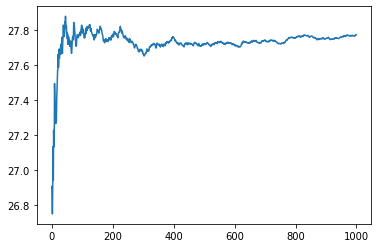

In [42]:
cum_sum = np.cumsum(u_mean_samples_mc, axis=0)
cum_mean = cum_sum / (1 + np.arange(num_samples))[:, np.newaxis]
cum_mean_norm = np.linalg.norm(cum_mean, axis=1)
plt.plot(cum_mean_norm)

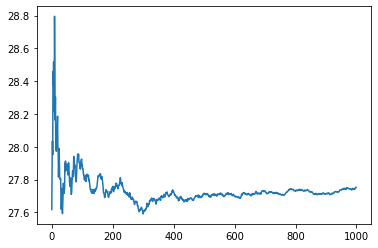

In [43]:
cum_sum = np.cumsum(u_samples_mc, axis=0)
cum_mean = cum_sum / (1 + np.arange(num_samples))[:, np.newaxis]
cum_mean_norm = np.linalg.norm(cum_mean, axis=1)
plt.plot(cum_mean_norm)

 20%|█▉        | 199/1000 [00:16<01:07, 11.91it/s]

0.55


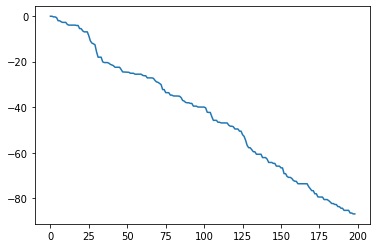

/Users/jp2011/workplace/firedrake/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.
/Users/jp2011/workplace/firedrake/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
 40%|███▉      | 399/1000 [00:33<00:51, 11.64it/s]

0.505


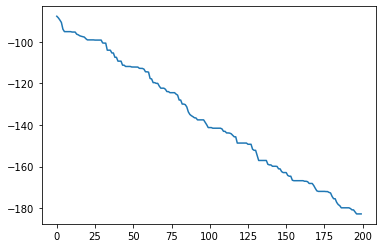

/Users/jp2011/workplace/firedrake/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.
/Users/jp2011/workplace/firedrake/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: overflow encountered in exp
 60%|█████▉    | 599/1000 [00:51<00:36, 10.91it/s]

0.495


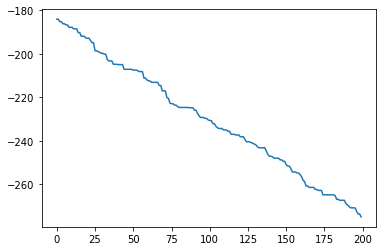

/Users/jp2011/workplace/firedrake/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: covariance is not positive-semidefinite.
 69%|██████▊   | 687/1000 [00:59<00:27, 11.53it/s]


KeyboardInterrupt: 

In [58]:
def log_likelihood(u: np.ndarray, 
                   b: np.ndarray,
                   A: np.ndarray, 
                   G: np.ndarray):
    (_, log_det) = np.linalg.slogdet(A) # A is pos. definite so sign ignored
    result = log_det
    result += np.dot(u, np.dot(A, np.linalg.solve(G, b)))
    result = result -0.5 * np.dot(u, np.dot(A, np.linalg.solve(G, np.dot(A, u))))
    return result


u_samples_mcmc = np.zeros((num_samples, M))
omega_samples_mcmc = np.zeros(num_samples)

warmup_interval_check = 200
num_samples_warmup = 1_000
omega_warmup_samples = []
accepted = 0

omega = np.random.normal(0, 1e-1)
u = np.zeros(M)

prop_std = 1e0 # initial value for the std of the proposal

for n in tqdm(range(num_samples_warmup)):
    
    # Recalibrate proposal density for ω
    if (n + 1) % warmup_interval_check == 0:
        ar = float(accepted) / float(warmup_interval_check)
        print(ar)
        if ar < 0.2:
            prop_std -= .1 * prop_std
            prop_std = np.max(1.e-5, prop_std)
        elif ar > 0.4:
            prop_std += .1 * prop_std
        else:
            print("ZEN")   
        accepted = 0
        plt.plot(np.asarray(omega_warmup_samples))
        plt.show()
        omega_warmup_samples = []
  
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    A = assemble((dot(grad(v), Constant(omega) * grad(u_trial))) * dx, bcs=bc)
    A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    A_inv_np = np.linalg.inv(A_np)
    
    u_mean = Function(V)
    solve(A, u_mean, b) # firedrake solve
    u_cov = A_inv_np @ G_np @ A_inv_np

    # 1. sample from p(u|ω) using a closed form expression
    u = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)
    
    # 2. sample from p(ω|u) via a Metropolis-step
    omega_star = omega_proposal_sample(omega, prop_std)
    
    u_trial = TrialFunction(V)
    v = TestFunction(V)
    A_star = assemble((dot(grad(v), Constant(omega_star) * grad(u_trial))) * dx, bcs=bc)
    A_star_np = A_star.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
    A_star_inv_np = np.linalg.inv(A_star_np)
    
    u_mean_star = Function(V)
    solve(A_star, u_mean_star, b) # firedrake solve
    u_cov_star = A_star_inv_np @ G_np @ A_star_inv_np
    
    log_p_u_given_omega_star = log_likelihood(u, b_np, A_star_np, G_np)
    log_p_u_given_omega = log_likelihood(u, b_np, A_np, G_np)
    log_ar = log_p_u_given_omega_star + omega_prior_logpdf(omega_star, omega_prior_loc, omega_prior_scale) + omega_proposal_logpdf(omega_star, omega, prop_std)
    log_ar = log_ar - log_p_u_given_omega - omega_prior_logpdf(omega, omega_prior_loc, omega_prior_scale) - omega_proposal_logpdf(omega, omega_star, prop_std)
    
    if np.exp(log_ar) > np.random.uniform(0, 1):
        accepted += 1
        omega = omega_star
    omega_warmup_samples.append(omega)
    
# by now the proposal is calibrated, just sample
# accepted = 0
# for n in tqdm(range(num_samples)):
#     u_trial = TrialFunction(V)
#     v = TestFunction(V)
#     A = assemble((dot(grad(v), Constant(omega) * grad(u_trial))) * dx, bcs=bc)
#     A_np = A.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
#     A_inv_np = np.linalg.inv(A_np)
    
#     u_mean = Function(V)
#     solve(A, u_mean, b) # firedrake solve
#     u_cov = A_inv_np @ G_np @ A_inv_np

#     # 1. sample from p(u|ω) using a closed form expression
#     u = np.random.multivariate_normal(u_mean.vector().dat.data, u_cov)
    
#     # 2. sample from p(ω|u) via a Metropolis-step
#     omega_star = omega_proposal_sample(omega, prop_std)
    
#     u_trial = TrialFunction(V)
#     v = TestFunction(V)
#     A_star = assemble((dot(grad(v), Constant(omega_star) * grad(u_trial))) * dx, bcs=bc)
#     A_star_np = A_star.petscmat.getValues(np.arange(G.nx).astype(np.int32), np.arange(G.nx).astype(np.int32))
#     A_star_inv_np = np.linalg.inv(A_star_np)
    
#     u_mean_star = Function(V)
#     solve(A_star, u_mean_star, b) # firedrake solve
#     u_cov_star = A_star_inv_np @ G_np @ A_star_inv_np
    
#     log_p_u_given_omega_star = log_likelihood(u, b_np, A_star_np, G_np)
#     log_p_u_given_omega = log_likelihood(u, b_np, A_np, G_np)
#     log_ar = log_p_u_given_omega_star + omega_prior_logpdf(omega_star, omega_prior_loc, omega_prior_scale) + omega_proposal_logpdf(omega_star, omega, prop_std)
#     log_ar = log_ar - log_p_u_given_omega - omega_prior_logpdf(omega, omega_prior_loc, omega_prior_scale) - omega_proposal_logpdf(omega, omega_star, prop_std)
    
#     if np.exp(log_ar) > np.random.uniform(0, 1):
#         accepted += 1
#         omega = omega_star
#     u_samples_mcmc[n, :] = u.copy()
#     omega_samples_mcmc[n] = omega

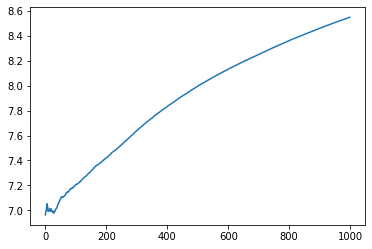

In [47]:
cum_sum = np.cumsum(u_samples_mcmc, axis=0)
cum_mean = cum_sum / (1 + np.arange(num_samples))[:, np.newaxis]
cum_mean_norm = np.linalg.norm(cum_mean, axis=1)
plt.plot(cum_mean_norm)

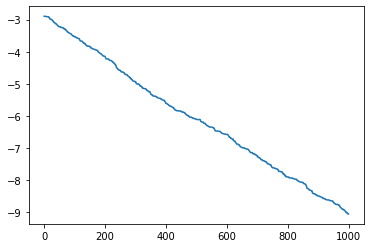

In [49]:
plt.plot(omega_samples_mcmc)